# BASELINE USING SMP U-Net


In [1]:
train = True

In [2]:
train

True

In [3]:
# !pip install segmentation_models_pytorch
# !pip install warmup_scheduler
# !pip install lion-pytorch

import sys
sys.path.append("/kaggle/input/efficientnet-pytorch/")
!pip install /kaggle/input/segmodelpytorchwheel/wheel/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmodelpytorchwheel/wheel/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmodelpytorchwheel/wheel/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmodelpytorchwheel/wheel/segmentation_models_pytorch-0.3.2-py3-none-any.whl

!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth /root/.cache/torch/hub/checkpoints/efficientnet-b5-586e6cc6.pth

Processing /kaggle/input/segmodelpytorchwheel/wheel/timm-0.6.12-py3-none-any.whl
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
Processing /kaggle/input/segmodelpytorchwheel/wheel/efficientnet_pytorch-0.7.1-py3-none-any.whl
Processing /kaggle/input/segmodelpytorchwheel/wheel/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /kaggle/input/segmodelpytorchwheel/wheel/segmentation_models_pytorch-0.3.2-py3-none-any.whl


# Lets import the libraries

In [4]:
if train == True:
    !pip install warmup_scheduler

  Preparing metadata (setup.py) ... done
  Created wheel for warmup_scheduler: filename=warmup_scheduler-0.3-py3-none-any.whl size=2982 sha256=653f6c70ee4c055306b3cb10037b023ee58bb582cee2d0a555fb91e98f906051
  Stored in directory: /root/.cache/pip/wheels/59/01/9e/d1820991c32916e9808c940f572b462f3e46427f3e76c4d852
Successfully built warmup_scheduler


In [5]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import matplotlib.pyplot as plt
import sys
import os
import gc
import sys
import pickle
import warnings
import math
import time
import random
import argparse
import importlib
from tqdm.auto import tqdm
from functools import partial
sys.path.append("/kaggle/input/lion-pytorch/lion-pytorch-main")
from lion_pytorch import Lion

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import segmentation_models_pytorch as smp
# from warmup_scheduler import GradualWarmupScheduler
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import datetime

In [6]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import json
from PIL import Image
from IPython.display import IFrame


In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Configuration Class

In [8]:
import random
class CFG:
    # ============== comp exp name =============
    comp_name = 'HuBMAP'
    exp_name = 'efficientnet-b4'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'HuBMAP-Hacking-the-Human-Vasculature'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'efficientnet-b5' #'se_resnext50_32x4d'

    in_chans = 3 # 65
    # ============== training cfg =============
    size = 512
    tile_size = 512
    stride = tile_size // 3

    train_batch_size = 14 # 32
    valid_batch_size = train_batch_size * 1
    use_amp = True

#     scheduler = 'GradualWarmupSchedulerV2' # 'GradualWarmupSchedulerV2' # 'CosineAnnealingLR'
    epochs = 1 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============


#     objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
#     metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 2

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')
    train_dir = "/kaggle/input/hubmap-hacking-the-human-vasculature/train"
    test_dir = "/kaggle/input/hubmap-hacking-the-human-vasculature/test"
    labels_file = '../input/hubmap-hacking-the-human-vasculature/polygons.jsonl'

    outputs_path = f'/kaggle/working/outputs/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    
    train_aug_list = [
        A.Resize(size, size),
        A.OneOf([A.HorizontalFlip(p=random.random()),
                 A.VerticalFlip(p=random.random())],p=random.random()),
        A.OneOf([A.HorizontalFlip(p=random.random()),
                 A.VerticalFlip(p=random.random())],p=random.random()),
        A.OneOf([A.HorizontalFlip(p=random.random()),
                 A.VerticalFlip(p=random.random())],p=random.random()),
        A.OneOf([A.HorizontalFlip(p=random.random()),
                 A.VerticalFlip(p=random.random())],p=random.random()),
        
        A.RandomBrightnessContrast(p=random.random()),
        A.ShiftScaleRotate(p=random.random()),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=random.random()),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=random.random()),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.2), max_height=int(size * 0.1), 
                        mask_fill_value=0, p=random.random()),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(),
    ]

set dataset path


In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 310
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

Logger = init_logger(log_file=CFG.log_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lets read the images

In [14]:
# class hubmapDataset(Dataset):
    
#     def __init__(self, cfg, transform = False, ):
        
#         with open(cfg.labels_file, 'r') as json_file:
#             self.json_labels = [json.loads(line) for line in json_file]
    
#         self.image_dir = cfg.train_dir
# #         self.transform = transform
#         self.transform = transform

#     __len__ = lambda self : len(self.json_labels)    
        
#     def __getitem__(self, idx):
        
#         image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
#         image = Image.open(image_path)
#         image= np.array(image)
                
#         mask = np.zeros((512, 512), dtype=np.float32)

#         for annot in self.json_labels[idx]['annotations']:

#             cords = annot['coordinates']
            
# #             if annot['type'] == "blood_vessel":
#             if(1):

#                 for cord in cords:
                    
#                     rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                    
#                     mask[rr, cc] = 1

        
        

#         if self.transform:
#             data = self.transform(image=image, mask=mask)
        
#         image = data['image']
#         mask = data['mask']
        

#         return image, mask

In [15]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug


In [16]:
# dataset = hubmapDataset(CFG,get_transforms("train",CFG))

# Lets make the Loader and Split into train_val 

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

**20% of the train is split into the validation set**

In [18]:
# train_data, val_data = train_test_split(dataset, test_size=0.25, random_state=42)

In [19]:
# del dataset
# gc.collect()

In [20]:
# len(train_data), len(val_data)

In [21]:
# train_loader = DataLoader(train_data,
#                           batch_size=CFG.train_batch_size, 
#                           shuffle=True,drop_last=True)
# valid_loader = DataLoader(val_data, batch_size=CFG.valid_batch_size,
#                          shuffle=False,
#                          drop_last=False)

In [22]:

# gc.collect()

In [23]:
# del train_data ,val_data
# gc.collect

# Lets write the model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name="efficientnet-b5", 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation="sigmoid",
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


# def build_model(cfg, weight="imagenet"):
#     print('model_name', cfg.model_name)
#     print('backbone', cfg.backbone)

#     model = CustomModel(cfg, weight)
#     return model

In [25]:
# can add schedulers

In [26]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

if train == True:
    from warmup_scheduler import GradualWarmupScheduler


    class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        """
        https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
        """
        def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(
                optimizer, multiplier, total_epoch, after_scheduler)

        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [
                            base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

    def get_scheduler(cfg, optimizer):
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

        return scheduler

    def scheduler_step(scheduler, avg_val_loss, epoch):
        scheduler.step(epoch)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# if train == True:
#     # model = build_model(CFG)
#     # model = CustomModel(CFG,"imagenet")

#     model = torch.load("/kaggle/input/hubmap-model-effnet-unet-30epoch-0-9504/epoch_15_loss_0_9018_effnetb05_unet.pt")

#     model=model.cuda()
#     # model.load_state_dict(torch.load("/kaggle/input/epoch-5-loss-0-8509-resnet34-deeplabv3/epoch_5_loss_0_8509_resnet34_DeepLabV3.pth"))
#     optimizer = Adam(model.parameters(), lr=1e-6) # lr after 30 epch 9.999999999999999e-06
#     # optimizer = Lion(model.parameters(),lr=CFG.lr,weight_decay=CFG.weight_decay)
#     scheduler = get_scheduler(CFG, optimizer)
# else:
#     model = torch.load("/kaggle/input/hubmap-model-effnet-unet-30epoch-0-9504/epoch_15_loss_0_9018_effnetb05_unet.pt")
#     model = model.to(device)

In [29]:
# model = torch.load("/kaggle/input/hubmap-model-effnet-unet-30epoch-0-9504/fold_4_epoch_45_loss_0_9018_effnetb05_unet.pt",map_location=device)

# model = model.to(device)

In [30]:
# type(model)

In [32]:

# predict_mask(img_path,mask_path)

# Losses

In [33]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss(pos_weight=torch.tensor(3))

alpha = 0.7
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
#     return BCELoss(y_pred, y_true)
    return 0.6 * BCELoss(y_pred, y_true) + 0.4 * TverskyLoss(y_pred, y_true)

In [34]:
def train_fn(train_loader, model, criterion, optimizer, device):
    

#     scaler = GradScaler(enabled=CFG.use_amp)
    
    losses = AverageMeter()
    train_loss = 0
    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        model.train()
        images = images.to(device).float()
        labels = labels.to(device).float()
        batch_size = labels.size(0)
        labels = torch.unsqueeze(labels, dim=1)
        with autocast(CFG.use_amp):
        
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return train_loss/len(train_loader)


In [35]:
def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device).float()
        labels = labels.to(device).float()
        labels = torch.unsqueeze(labels, dim=1)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
#             y_preds = torch.squeeze(y_preds, dim=1)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        images.detach()
        labels=labels.to('cpu').numpy()

        
    return losses.avg, y_preds ,labels

# Metric for this compitition

****Average precission****

In [36]:
import torch
from sklearn.metrics import average_precision_score

def calculate_average_precision(predicted_masks, true_masks):
    """
    Calculates the average precision for a segmentation task.

    Args:
        predicted_masks (numpy.ndarray): Predicted masks with shape (N, H, W).
        true_masks (torch.Tensor): True masks with shape (N, H, W) or (H, W).

    Returns:
        float: Average precision score.
    """
#     if true_masks.dim() == 2:
#         true_masks = true_masks.unsqueeze(0)  # Add a dimension for the number of samples

    predicted_masks_2d = predicted_masks.reshape(predicted_masks.shape[0], -1)
    true_masks_2d = true_masks.reshape(true_masks.shape[0], -1)

    ap = average_precision_score(true_masks_2d, predicted_masks_2d, average='macro')
    return ap

def calc_ap(true_masks, predicted_masks):
    true_masks = true_masks.astype(int).flatten()
    predicted_masks = predicted_masks.flatten()

    best_th = 0
    best_ap = 0
    for th in np.array(range(10, 50+1, 2)) / 100:
        
        ap = calculate_average_precision(true_masks, (predicted_masks >= th).astype(int))
        print(f'th: {th}, AvgP: {ap}')

        if ap > best_ap:
            best_ap = ap
            best_th = th
    
    Logger.info(f'best_th: {best_th}, AvgP: {best_ap}')
    return best_ap, best_th


def calc_cv(mask_gt, mask_pred):
    best_ap, best_th = calc_ap(mask_gt, mask_pred)

    return best_ap, best_th

# Training

In [37]:
# if CFG.metric_direction == 'minimize':
#     best_score = np.inf
# elif CFG.metric_direction == 'maximize':
#     best_score = -1

# best_loss = np.inf

# prev_loss_tr = 1
# prev_loss_vl = 0

# for epoch in range(5):

#     start_time = time.time()

#     # train
#     avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

#     # eval
#     avg_val_loss, mask_pred, valid_mask_gt  = valid_fn(
#         valid_loader, model, criterion, device)
    
    
        
#     scheduler_step(scheduler, avg_val_loss, epoch)
    
#     best_ap, best_th = calc_cv(valid_mask_gt, mask_pred)

#     # score = avg_val_loss
#     score = best_ap

#     elapsed = time.time() - start_time
    
#     Logger.info(
#         f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
#     Logger.info(f'Epoch {epoch+1} - avgScore: {score:.4f}')
#     Logger.info(
#         f'Epoch {epoch+1} - avgScore: {score:.4f}')

#     if CFG.metric_direction == 'minimize':
#         update_best = score < best_score
#     elif CFG.metric_direction == 'maximize':
#         update_best = score > best_score

    
    
#     if update_best:
#         best_loss = avg_val_loss
#         best_score = score

#         Logger.info(
#             f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
#         Logger.info(
#             f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
#         torch.save({'model': model.state_dict(),
#                     'preds': mask_pred},
#                     CFG.model_dir + f'{CFG.backbone}_best.pth')
        

# #     if (-( avg_loss - prev_loss_tr )/prev_loss_tr)*100 < 2:
# #         print(epoch)
# #         break
# #     prev_loss_tr = avg_loss
    

In [38]:
import torch
import copy

def weighted_average_models(model1, model2, weight=0.7):
    """
    Returns a model with weighted averaged parameters from model1 and model2.

    Args:
        model1 (torch.nn.Module): First PyTorch model.
        model2 (torch.nn.Module): Second PyTorch model.
        weight (float): Weight for averaging the models (between 0 and 1).

    Returns:
        torch.nn.Module: New model with weighted averaged parameters.
    """
    assert 0 <= weight <= 1, "Weight parameter must be between 0 and 1."
    print("weighted averaged model")
    # Create a deep copy of model1 to avoid modifying the original models
    averaged_model = copy.deepcopy(model1)

    # Get the state dictionaries of both models
    model1_state_dict = model1.state_dict()
    model2_state_dict = model2.state_dict()

    # Iterate over the parameters and perform the weighted average
    for param_name in model1_state_dict:
        model1_param = model1_state_dict[param_name]
        model2_param = model2_state_dict[param_name]
        averaged_param = (1 - weight) * model1_param +  weight * model2_param
        averaged_model.state_dict()[param_name].copy_(averaged_param)

    return averaged_model


In [39]:
import glob
from sklearn.model_selection import KFold
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs#sorted(glob.glob('/kaggle/input/hubmap-making-dataset/train/image/*.png'))
        self.masks = masks#sorted(glob.glob('/kaggle/input/hubmap-making-dataset/train/mask/*.png'))

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        mask = Image.open(mask_path).convert('L')
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        mask = np.where(mask > 0, 1.0, 0.0)
        
        
        
        if self.transforms is not None:
            tr = self.transforms(image=img, image2=mask)
            img , mask = tr["image"],tr["image2"]
        
        else:
            mask = torch.from_numpy(mask).float()
            img = torch.from_numpy(img).permute(2,0,1).float()
#         print(img,mask)      
        return img, mask

    def __len__(self):
        return len(self.imgs)

n_imgs = len(glob.glob('/kaggle/input/creating-dataset/train/image/*'))
n_imgs



1622

In [43]:

img_path= "/kaggle/input/creating-dataset/train/image/004daf1cbe75.png"
mask_path = "/kaggle/input/creating-dataset/train/mask/004daf1cbe75_mask.png"


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read the PNG file
def predict_mask(model,img_path,mask_path):
    image = mpimg.imread(img_path)

    # Read another image for comparison

    another_image = mpimg.imread(mask_path)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3)

    # Display the first image in the first subplot
    axes[0].imshow(image)
    axes[0].set_title('Image 1')

    # Display the second image in the second subplot
    axes[1].imshow(another_image)
    axes[1].set_title('Image 2')
    x = torch.from_numpy(image)
    x = x.permute(2,0,1)
    axes[2].imshow(predict(model,x))
    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def predict(model,x):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        y = model(x.unsqueeze(dim=0).to(device))

    y = y/torch.max(y).item()
    y = torch.where(y < 0.5, torch.tensor(0.0), torch.tensor(1.0))
    numpy_image = torchvision.transforms.ToPILImage()(y.squeeze(0)).convert("RGB")
    return numpy_image

0
epoch: 0


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 1 - avg_train_loss: 0.8779  avg_val_loss: 0.8754  time: 123s
Epoch 1 - avgScore: 1.0000
Epoch 1 - avgScore: 1.0000
Epoch 1 - Save Best Score: 1.0000 Model
Epoch 1 - Save Best Loss: 0.8754 Model


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 1


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 2 - avg_train_loss: 0.8782  avg_val_loss: 0.8785  time: 123s
Epoch 2 - avgScore: 1.0000
Epoch 2 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 2


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 3 - avg_train_loss: 0.8786  avg_val_loss: 0.8709  time: 123s
Epoch 3 - avgScore: 1.0000
Epoch 3 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 3


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 4 - avg_train_loss: 0.8687  avg_val_loss: 0.8302  time: 123s
Epoch 4 - avgScore: 1.0000
Epoch 4 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 4


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 5 - avg_train_loss: 0.8684  avg_val_loss: 0.8609  time: 123s
Epoch 5 - avgScore: 1.0000
Epoch 5 - avgScore: 1.0000


th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 5


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 6 - avg_train_loss: 0.8653  avg_val_loss: 0.8652  time: 123s
Epoch 6 - avgScore: 1.0000
Epoch 6 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 6


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 7 - avg_train_loss: 0.8712  avg_val_loss: 0.8556  time: 122s
Epoch 7 - avgScore: 1.0000
Epoch 7 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 7


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 8 - avg_train_loss: 0.8666  avg_val_loss: 0.8680  time: 122s
Epoch 8 - avgScore: 1.0000
Epoch 8 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 8


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 9 - avg_train_loss: 0.8673  avg_val_loss: 0.8305  time: 123s
Epoch 9 - avgScore: 1.0000
Epoch 9 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 9


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 10 - avg_train_loss: 0.8687  avg_val_loss: 0.8638  time: 123s
Epoch 10 - avgScore: 1.0000
Epoch 10 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0


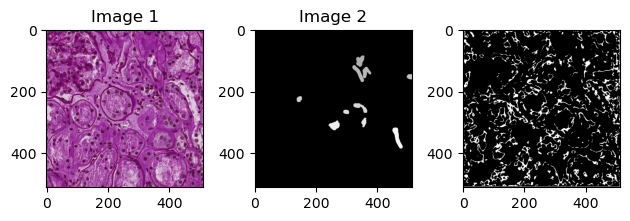

1
epoch: 0


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 1 - avg_train_loss: 0.8683  avg_val_loss: 0.8716  time: 123s
Epoch 1 - avgScore: 1.0000
Epoch 1 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 1


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 2 - avg_train_loss: 0.8686  avg_val_loss: 0.8743  time: 123s
Epoch 2 - avgScore: 1.0000
Epoch 2 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 2


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 3 - avg_train_loss: 0.8668  avg_val_loss: 0.8346  time: 123s
Epoch 3 - avgScore: 1.0000
Epoch 3 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 3


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 4 - avg_train_loss: 0.8675  avg_val_loss: 0.8358  time: 122s
Epoch 4 - avgScore: 1.0000
Epoch 4 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 4


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 5 - avg_train_loss: 0.8684  avg_val_loss: 0.8505  time: 123s
Epoch 5 - avgScore: 1.0000
Epoch 5 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 5


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 6 - avg_train_loss: 0.8638  avg_val_loss: 0.8631  time: 123s
Epoch 6 - avgScore: 1.0000
Epoch 6 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 6


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 7 - avg_train_loss: 0.8658  avg_val_loss: 0.8631  time: 123s
Epoch 7 - avgScore: 1.0000
Epoch 7 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 7


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 8 - avg_train_loss: 0.8682  avg_val_loss: 0.8691  time: 123s
Epoch 8 - avgScore: 1.0000
Epoch 8 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 8


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 9 - avg_train_loss: 0.8677  avg_val_loss: 0.8712  time: 123s
Epoch 9 - avgScore: 1.0000
Epoch 9 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 9


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 10 - avg_train_loss: 0.8685  avg_val_loss: 0.8713  time: 123s
Epoch 10 - avgScore: 1.0000
Epoch 10 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0


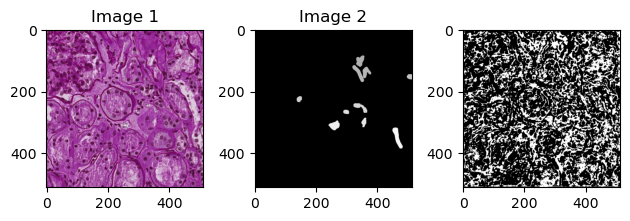

2
weighted averaged model
epoch: 0


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 1 - avg_train_loss: 0.8709  avg_val_loss: 0.8724  time: 123s
Epoch 1 - avgScore: 1.0000
Epoch 1 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 1


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 2 - avg_train_loss: 0.8674  avg_val_loss: 0.8689  time: 123s
Epoch 2 - avgScore: 1.0000
Epoch 2 - avgScore: 1.0000


th: 0.32, AvgP: 1.0
th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 2


  0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, AvgP: 1.0
th: 0.12, AvgP: 1.0
th: 0.14, AvgP: 1.0
th: 0.16, AvgP: 1.0
th: 0.18, AvgP: 1.0
th: 0.2, AvgP: 1.0
th: 0.22, AvgP: 1.0
th: 0.24, AvgP: 1.0
th: 0.26, AvgP: 1.0
th: 0.28, AvgP: 1.0
th: 0.3, AvgP: 1.0
th: 0.32, AvgP: 1.0


best_th: 0.1, AvgP: 1.0
Epoch 3 - avg_train_loss: 0.8664  avg_val_loss: 0.8717  time: 123s
Epoch 3 - avgScore: 1.0000
Epoch 3 - avgScore: 1.0000


th: 0.34, AvgP: 1.0
th: 0.36, AvgP: 1.0
th: 0.38, AvgP: 1.0
th: 0.4, AvgP: 1.0
th: 0.42, AvgP: 1.0
th: 0.44, AvgP: 1.0
th: 0.46, AvgP: 1.0
th: 0.48, AvgP: 1.0
th: 0.5, AvgP: 1.0
epoch: 3


  0%|          | 0/162 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
import torchvision
if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1
torch.cuda.empty_cache()
best_loss = np.inf

prev_loss_tr = 1
prev_loss_vl = 0
model = torch.load("/kaggle/input/hubmap-model-effnet-unet-30epoch-0-9504/fold_4_epoch_45_loss_0_9018_effnetb05_unet.pt")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(range(n_imgs))):
    fold = i
    print(fold)
#     if i!=0: continue
    all_imgs = sorted(glob.glob('/kaggle/input/creating-dataset/train/image/*.png'))
    all_masks = sorted(glob.glob('/kaggle/input/creating-dataset/train/mask/*.png'))
    
    all_imgs = np.array(all_imgs)
    all_masks = np.array(all_masks)
    train_img = all_imgs[train_index]
    train_mask = all_masks[train_index]
    val_img = all_imgs[test_index]
    val_mask = all_masks[test_index]
    
    dataset_train = PennFudanDataset(train_img, train_mask,get_transforms(data='train', cfg=CFG))
    dataset_val = PennFudanDataset(val_img, val_mask,get_transforms(data='valid', cfg=CFG))
    
    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=8, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)    
    del dataset_val,dataset_train
    gc.collect()
    if fold > 1:
        model0 = torch.load(f"/kaggle/working/fold_{fold-2}_epoch_45_loss_0_9018_effnetb05_unet.pt")
        model1 = torch.load(f"/kaggle/working/fold_{fold-1}_epoch_45_loss_0_9018_effnetb05_unet.pt")
        model  = weighted_average_models(model0,model1)
    model = model.cuda()
    
    optimizer = Adam(model.parameters(), lr=1e-5) # lr after 30 epch 9.999999999999999e-06
#     optimizer = Lion(model.parameters(),lr=CFG.lr,weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(CFG, optimizer)
    
    
    for epoch in range(10):
        print(f"epoch: {epoch}")
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

        # eval
        avg_val_loss, mask_pred, valid_mask_gt  = valid_fn(
            valid_loader, model, criterion, device)



        scheduler_step(scheduler, avg_val_loss, epoch)

        best_ap, best_th = calc_cv(valid_mask_gt, mask_pred)

        # score = avg_val_loss
        score = best_ap

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        Logger.info(f'Epoch {epoch+1} - avgScore: {score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avgScore: {score:.4f}')

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score



        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            torch.save({'model': model.state_dict(),
                        'preds': mask_pred},
                        CFG.model_dir + f'{CFG.backbone}_best.pth')
    predict_mask(model,img_path,mask_path)
    del train_loader
    del valid_loader
    gc.collect()
    torch.save(model,f"/kaggle/working/fold_{fold}_epoch_45_loss_0_9018_effnetb05_unet.pt")
    #     if (-( avg_loss - prev_loss_tr )/prev_loss_tr)*100 < 2:
    #         print(epoch)
    #         break
    #     prev_loss_tr = avg_loss
    

In [ ]:
torch.save(model,"/kaggle/working/epoch_40_loss_0_9018_effnetb05_unet.pt")

In [ ]:
from IPython.display import FileLink
display(FileLink("epoch_15_loss_0_9018_effnetb05_unet.pt"))

In [ ]:
# !pip install --no-index --no-deps /kaggle/input/pycocotools-206/wheels/*.whl

In [ ]:
# # !pip install --no-index --no-deps /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl
# import 
# import base64
# import numpy as np
# from pycocotools import _mask as coco_mask
# import typing as t
# import zlib
# import os
# import cv2
# import matplotlib.pyplot as plt
# import pandas as pd

# def encode_binary_mask(mask: np.ndarray) -> t.Text:
#     """Converts a binary mask into OID challenge encoding ascii text."""

#     # check input mask --
#     if mask.dtype != bool:
#         raise ValueError(
#             "encode_binary_mask expects a binary mask, received dtype == %s" %
#             mask.dtype)

#     mask = np.squeeze(mask)
#     if len(mask.shape) != 2:
#         raise ValueError(
#             "encode_binary_mask expects a 2d mask, received shape == %s" %
#             mask.shape)

#     # convert input mask to expected COCO API input --
#     mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
#     mask_to_encode = mask_to_encode.astype(np.uint8)
#     mask_to_encode = np.asfortranarray(mask_to_encode)

#     # RLE encode mask --
#     encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

#     # compress and base64 encoding --
#     binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
#     base64_str = base64.b64encode(binary_str)
#     return base64_str

# def get_pred_string(objs):

#     string = ""
#     for i, item in enumerate(objs):
# #         mask = np.zeros((512,512), np.bool8) #change here
# #         mask[item>0] = 1
#         mask_array = np.zeros((512, 512),np.bool8)

#     # Set mask values to 1 where input_array > 0
#         mask_array[np.sum(objs, axis=2) > 0] = 1
# #         print(item.shape)
#         encoded_mask = encode_binary_mask(mask_array).decode("utf-8")

#         if i == 0:
#             string += f"0 1.0 {encoded_mask}"
#         else:
#             string += f" 0 1.0 {encoded_mask}"
        
#     return string



# test_path = "/kaggle/input/hubmap-hacking-the-human-vasculature/test/"
# submission = pd.DataFrame()

# ids = []
# h = []
# w = []
# pred_strings = []
    
# for img_id in os.listdir(test_path):
#     curr_img = cv2.imread(test_path + img_id)
#     ## Get id, height, width
#     height, width, channels = curr_img.shape
#     curr_img = torch.from_numpy(cv2.imread(test_path + img_id)).permute(2,0,1)
#     ids.append(img_id.split(".")[0])
#     h.append(height)
#     w.append(width)
    
    
    
#     ## Get prediction_string
#     pred_strings.append(get_pred_string(curr_img))

# submission["id"] = ids
# submission["height"] = h
# submission["width"] = w
# submission["prediction_string"] = pred_strings
# submission.set_index("id", inplace=True)
# submission